In [1]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(8,8)

In [2]:
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 16
}  
def setfigform_simple(xlabel, ylabel=None, xlimit = (None,None), ylimit = (None, None), xticks=None, yticks=None):
    # plt.legend(fontsize = 16, frameon=False),
    plt.xlabel(xlabel, fontdict = font)
    plt.ylabel(ylabel, fontdict = font)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    if xticks is not None:
      plt.xticks([])
    else:
      plt.xticks(fontsize = font['size'], fontname = "serif")
    if yticks is not None:
      plt.yticks([])
    else:
      plt.yticks(fontsize = font['size'], fontname = "serif")
    plt.tick_params(direction="in")

In [3]:
import torch
import seaborn as sns
from torch.autograd import grad as torchgrad

In [4]:

def HMCwithAccept(energy,x,length,steps,epsilon):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]

    torch.set_grad_enabled(False)
    E = energy(x)
    torch.set_grad_enabled(True)
    g = grad(x.requires_grad_())
    torch.set_grad_enabled(False)
    g = g.detach()
    for l in range(length):
        p = x.new_empty(size=x.size()).normal_()
        H = ((0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + E)
        xnew = x
        gnew = g
        for _ in range(steps):
            p = p- epsilon* gnew/2.
            xnew = (xnew + epsilon * p)
            torch.set_grad_enabled(True)
            gnew = grad(xnew.requires_grad_())
            torch.set_grad_enabled(False)
            xnew = xnew.detach()
            gnew = gnew.detach()
            p = p- epsilon* gnew/2.
        Enew = energy(xnew)
        Hnew = (0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + Enew
        diff = H-Hnew
        accept = (diff.exp() >= diff.uniform_()).to(x)

        E = accept*Enew + (1.-accept)*E
        acceptMask = accept.reshape(shape)
        x = acceptMask*xnew + (1.-acceptMask)*x
        g = acceptMask*gnew + (1.-acceptMask)*g
    torch.set_grad_enabled(True)

    return x, accept

def HMC(*args,**kwargs):
    x, _ = HMCwithAccept(*args,**kwargs)
    return x

class Lattice:
    def __init__(self,L, d, BC='periodic'):
        self.L = L 
        self.d = d
        self.shape = [L]*d 
        self.Nsite = L**d 
        self.BC = BC

    def move(self, idx, d, shift):
        coord = self.index2coord(idx)
        coord[d] += shift

        if self.BC != 'periodic':
            if (coord[d]>=self.L) or (coord[d]<0):
                return None
        #wrap around because of the PBC
        if (coord[d]>=self.L): coord[d] -= self.L; 
        if (coord[d]<0): coord[d] += self.L; 

        return self.coord2index(coord)

    def index2coord(self, idx):
        coord = np.zeros(self.d, int) 
        for d in range(self.d):
            coord[self.d-d-1] = idx%self.L;
            idx /= self.L
        return coord 

    def coord2index(self, coord):
        idx = coord[0]
        for d in range(1, self.d):
            idx *= self.L; 
            idx += coord[d]
        return idx 

class Hypercube(Lattice):
    def __init__(self,L, d, BC='periodic'):
        super(Hypercube, self).__init__(L, d, BC)
        self.Adj = np.zeros((self.Nsite,self.Nsite), int)
        for i in range(self.Nsite):
            for d in range(self.d):
                j = self.move(i, d, 1)

                if j is not None:
                    self.Adj[i, j] = 1.0
                    self.Adj[j, i] = 1.0

from scipy.linalg import eigh, inv, det 
import math
class Ising:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        self.K = self.lattice.Adj*beta
    
        w, v = eigh(self.K)    
        offset = 0.1-w.min()
        # print("offset", offset)
        self.K += np.eye(w.size)*offset
        sign, logdet = np.linalg.slogdet(self.K)
        #print (sign)
        #print (0.5*self.nvars[0] *(np.log(4.)-offset - np.log(2.*np.pi)) - 0.5*logdet)
        self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        assert len(x.shape) == 2
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])).sum(dim=1) \
        + (torch.nn.Softplus()(2.*x.reshape(-1, self.nvars[0])) - x.reshape(-1, self.nvars[0]) - math.log(2.)).sum(dim=1))

    def lnZ(self,x):
        e = self.energy(x)
        Z = (torch.exp(-e)).sum()
        return torch.log(Z)


    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True).to(torch.float32)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()



# Diffusion

In [ ]:

def DiffusionwithDrift(energy,lnZ,x,D,length,epsilon,decay=0.9):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]
    epsilon = torch.tensor(epsilon)
    epsilon.requires_grad_(False)

    g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]

    g = g.detach()
    x = x.detach()
    x_t = []
    x_t.append(x)
    '''
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
    plt.colorbar()
    plt.subplot(132)
    _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
    _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
    plt.legend()
    plt.subplot(133)
    _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
    plt.xlabel("x")
    plt.ylabel("$Grad_x(P)$")
    '''

    for l in range(1, length+1):
        z = torch.normal(0,1,size=x.size())
        x = x + 0.5 * epsilon * g * D + epsilon.sqrt() * z
        # x = x + 0.5 * epsilon * g
        g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]
        x = x.detach()
        g = g.detach()
        epsilon*=decay
        

        if l %100 == 0:
            plt.figure(figsize=(17,5))
            plt.subplot(131)
            _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
            plt.colorbar()
            plt.subplot(132)
            _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
            _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
            plt.legend()
            plt.subplot(133)
            _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
            plt.xlabel("x")
            plt.ylabel("$Grad_x(P)$")

        x_t.append(x)
    return x_t


- Start distribution: N(0,1)
- End distribution: $k_BT=2.5J$
- Diffusion coeffient = 
    [0.00087473 0.00089455 0.00101424 0.00095392 0.00078433 0.00082617
     0.00078793 0.00121703 0.0008083  0.00076017 0.00064152 0.00078268
     0.00080268 0.00104615 0.0007548  0.00079117 0.00098635 0.00104748
     0.00099374 0.00086931 0.00081431 0.00067292 0.00089971 0.001025
     0.00094306 0.00090339 0.00100088 0.00083922 0.00086348 0.00085764
     0.00102415 0.000671   0.00067592 0.00078063 0.00068504 0.00080133]

In [ ]:
ising = Ising(6,2,0.4)
initial = torch.randn([10000]+ising.nvars,requires_grad=True)
thermolength = 1000
epsilon = 0.1
D = np.array([0.00087473, 0.00089455, 0.00101424, 0.00095392, 0.00078433, 0.00082617,
              0.00078793, 0.00121703, 0.0008083 , 0.00076017, 0.00064152, 0.00078268,
              0.00080268, 0.00104615, 0.0007548 , 0.00079117, 0.00098635, 0.00104748,
              0.00099374, 0.00086931, 0.00081431, 0.00067292, 0.00089971, 0.001025,
              0.00094306, 0.00090339, 0.00100088, 0.00083922, 0.00086348, 0.00085764,
              0.00102415, 0.000671  , 0.00067592, 0.00078063, 0.00068504, 0.00080133])
x_t = DiffusionwithDrift(ising.energy, ising.lnZ, initial, torch.from_numpy(D).to(torch.float32), thermolength, epsilon)

line_color = [plt.colormaps["gnuplot"](float(i)/float(thermolength+1)) for i in range(thermolength+1)]
plt.figure()
epsilon = 0.01
t=0
for i in range(0, len(x_t), 100):
    plt.hist(x_t[i].reshape(-1,36).sum(-1), bins=200, edgecolor=line_color[i], histtype='step', label="Time=%f, $\epsilon$=%f"%(t,epsilon))
    t+=epsilon
    epsilon*=0.9
plt.legend()

xx = x_t[-1]
plt.figure(figsize=(17, 5))
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)


# Implicit score matching

In [ ]:
# \psi(x), x is 2D
import torch
import torch.nn as nn
import torch.optim as optim
model_psi = nn.Sequential(
    nn.Linear(36, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

In [ ]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

In [ ]:
# Implicit score matching loss: L_{ISM}(\psi) = tr(\nabla_x \psi(x)) + \frac{1}{2}||\psi(x)||^2
def ism_loss(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    norm_loss = torch.norm(logp, dim=-1) ** 2/2
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

In [ ]:
dataset = xx3
def sample_batch_torch(size):
    idx = torch.randint(0, len(dataset), (size,))
    return dataset[idx]

In [ ]:
l_curve = []
print('[Training step, loss value]')
for training_step in range(5000):
    dataset = sample_batch_torch(3*10**2).float()
    # Compute the loss.
    loss = ism_loss(model_psi, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((training_step % 10) == 0):
        l_curve.append([training_step, loss.item()])
    if ((training_step % 500) == 0):
        print([training_step, loss.item()])

In [ ]:
n_steps=9
eps=1e-2
decay=.9
temperature=1.0

xx =  torch.normal(0, 1, size=(10**5,36))
xx_t = []
xx_t.append(xx.detach().numpy())

for ii in range(n_steps):
    z_t = torch.rand(xx.size())
    xx = xx + (eps / 2) * model_psi(xx) + (np.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,:],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2])
plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues')

plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[ii,:,:].sum(-1),bins=100)

plt.show()

# CFM by Gaussian probability path

In [ ]:
def cfm_loss(model, samples, u_t_label, train=False):
    samples.requires_grad_(True)
    u_t_model = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [15]:
dataset = xx2.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size=size)
    return dataset[idx]

In [16]:
dataset_prior = xx0.detach().numpy()
def sample_batch_prior(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset_prior)), size=size)
    return dataset_prior[idx]

## Trainning OT model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)



optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001


l_curve = []
l_curve_score = []
ising_tilde = Ising(6,2,0.4)
sample_size = 10**3
print('[Time step, loss value]')
for training_step in range(10000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    u_t_xx = (sample_x_tilde - (1 - sigma_min)*sample_x) / sigma_t
    u_t_label = torch.tensor(u_t_xx).float()

    loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    
    if ((training_step % 20) == 0):
        l_curve.append([training_step,loss.item()])
    if ((training_step % 200) == 0):
        print([training_step,loss.item()])

In [ ]:
l_curve_fm = np.array(l_curve)
plt.loglog(l_curve_fm[:,0],l_curve_fm[:,1])
plt.xlabel('Training Step')
plt.ylabel('OT Loss')
plt.show()

## Trainning score model by $\nabla lnp$

In [ ]:
from torch.autograd.functional import jacobian
def batch_jacobian(func, x):
  # x in shape (Batch, Length)
  def _func_sum(x):
    return func(x).sum(dim=0)
  return jacobian(_func_sum, x)

In [ ]:


model_s_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer_s = optim.Adam(model_s_t.parameters(), lr=3e-3)

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001


l_curve_score = []
ising_tilde = Ising(6,2,0.4)
sample_size = 10**3
print('[Time step, loss value]')
for training_step in range(10000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    # score_label = jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # score_label = torch.stack([jacobian(ising_tilde.energy, torch.from_numpy(x).reshape(1,36)).ravel() for x in sample_x], axis=0)
    score_label = batch_jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # plt.figure(figsize=(23,5))
    # plt.subplot(141)
    # plt.hist(sample_x.sum(-1), bins=100)
    # plt.subplot(142)
    # plt.hist2d(sample_x[:,0], sample_x[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.subplot(143)
    # plt.hist(score_label.sum(-1), bins=100)
    # plt.subplot(144)
    # plt.hist2d(score_label[:,0], score_label[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.show()

    # loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    score_loss = cfm_loss(model_s_t, torch.tensor(samples).float(), score_label)
    # Before the backward pass, zero all of the network gradients
    optimizer_s.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    score_loss.backward()
    # Calling the step function to update the parameters
    optimizer_s.step()
    
    if ((training_step % 20) == 0):
        l_curve_score.append([training_step,score_loss.item()])
    if ((training_step % 200) == 0):
        print([training_step, score_loss.item()])

In [ ]:
print('[Time step, loss value]')
l_curve_score = list(l_curve_score)
for training_step in range(10000, 15000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    # score_label = jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # score_label = torch.stack([jacobian(ising_tilde.energy, torch.from_numpy(x).reshape(1,36)).ravel() for x in sample_x], axis=0)
    score_label = batch_jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # plt.figure(figsize=(23,5))
    # plt.subplot(141)
    # plt.hist(sample_x.sum(-1), bins=100)
    # plt.subplot(142)
    # plt.hist2d(sample_x[:,0], sample_x[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.subplot(143)
    # plt.hist(score_label.sum(-1), bins=100)
    # plt.subplot(144)
    # plt.hist2d(score_label[:,0], score_label[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.show()

    # loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    score_loss = cfm_loss(model_s_t, torch.tensor(samples).float(), score_label)
    # Before the backward pass, zero all of the network gradients
    optimizer_s.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    score_loss.backward()
    # Calling the step function to update the parameters
    optimizer_s.step()
    
    if ((training_step % 20) == 0):
        l_curve_score.append([training_step,score_loss.item()])
    if ((training_step % 200) == 0):
        print([training_step, score_loss.item()])

In [ ]:
l_curve_score = np.array(l_curve_score)
plt.loglog(l_curve_score[:,0],l_curve_score[:,1])
plt.xlabel('Training Step')
plt.ylabel('Score Loss')
plt.show()

## Make a dataset of Boltzmann path with score: $s=\nabla lnp$

In [ ]:
sigma_min=0.0001
def sample_path(size, samplesize_per_beta=100):
    t = 1.-np.linspace(0,1,size//samplesize_per_beta)
    print("idx_t, t, beta, sample_x.shape, sample_t.shape")
    for idx_t in range(len(t)):
        sigma_t =  1 - (1-sigma_min) * t[idx_t]
        sample_x_tilde = sample_batch(size=samplesize_per_beta).reshape([-1,36])
        sample_x_ot_t = sample_batch_prior(size=samplesize_per_beta).reshape([-1,36])
        sample_x_ot_t *= sigma_t
        sample_x_ot_t += t[idx_t] * sample_x_tilde
        if idx_t == 0:
            sample_x_ot = sample_x_ot_t
        else:
            sample_x_ot = np.concatenate([sample_x_ot, sample_x_ot_t], axis=0)
        beta = 1./(7.5/(1-sigma_min)*t[idx_t]+2.5)
        ising_t = Ising(6,2,beta)
        if idx_t == 0:
            sample_x_t = ising_t.sample(samplesize_per_beta, thermalSteps=1000).reshape([-1,36]).detach().numpy()
            # score_label_t = batch_jacobian(ising_t.energy, torch.from_numpy(sample_x_t))
            sample_x = sample_x_t
            sample_t = np.ones([samplesize_per_beta,1])*t[idx_t]
            # score_label = score_label_t
        else:
            sample_x_t = ising_t.sample(samplesize_per_beta, thermalSteps=100, initial=torch.from_numpy(sample_x_t)).reshape([-1,36]).detach().numpy()
            # score_label_t = batch_jacobian(ising_t.energy, torch.from_numpy(sample_x_t))
            sample_x = np.concatenate([sample_x, sample_x_t], axis=0)
            sample_t = np.concatenate([sample_t, np.ones([samplesize_per_beta,1])*t[idx_t]], axis=0)
            # score_label = torch.cat([score_label, score_label_t])

        print(idx_t, t[idx_t], beta)
    return sample_t, sample_x, sample_x_ot

In [ ]:
dataset_t, dataset_path, dataset_ot = sample_path(100000)
print(dataset_t.shape, dataset_path.shape, dataset_ot.shape)

In [ ]:

def sample_batch_path(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset_path)), size=size)
    return dataset_t[idx], dataset_path[idx], dataset_ot[idx]

# Training geodesic model by distances between data and OT path

In [ ]:
def g_land(x, x_dataset, sigma=0.5, epsilon=0.01):
    assert len(x.shape) == 2, len(x_dataset.shape) == 2
    batchsize = x.shape[0]
    dim = x.shape[1]
    h_x = torch.zeros(x.shape)
    for i in range(len(x_dataset)):
        h_x += (x-x_dataset[i])**2*torch.exp(-((x-x_dataset[i])**2).sum(-1)[:,None]/2/(sigma**2))
    g_x = torch.inverse(h_x[:, :, None] * torch.eye(dim) + epsilon * torch.eye(dim).repeat(batchsize, 1, 1))
    return g_x

## Geodesic metric by RBF

In [17]:

class RBFN(object):

    def __init__(self, hidden_shape, sigma=1.0):
        """ radial basis function network
        # Arguments
            input_shape: dimension of the input data
            e.g. scalar functions have should have input_dimension = 1
            hidden_shape: the number
            hidden_shape: number of hidden radial basis functions,
            also, number of centers.
        """
        self.hidden_shape = hidden_shape
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _kernel_function(self, center, data_point):
        return np.exp(-self.sigma*np.linalg.norm(center-data_point)**2)

    def _calculate_interpolation_matrix(self, X):
        """ Calculates interpolation matrix using a kernel_function
        # Arguments
            X: Training data
        # Input shape
            (num_data_samples, input_shape)
        # Returns
            G: Interpolation matrix
        """
        G = np.zeros((len(X), self.hidden_shape))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(
                        center, data_point)
        return G

    def _select_centers(self, X):
        random_args = np.random.choice(len(X), self.hidden_shape)
        centers = X[random_args]
        return centers

    def fit(self, X, Y):
        """ Fits weights using linear regression
        # Arguments
            X: training samples
            Y: targets
        # Input shape
            X: (num_data_samples, input_shape)
            Y: (num_data_samples, input_shape)
        """
        self.centers = self._select_centers(X)
        G = self._calculate_interpolation_matrix(Y)
        # self.weights = np.dot(np.linalg.pinv(G), Y)
        print("G = ", G.shape, G.min(), G.max())
        print(G)
        self.weights = 1./G.sum(-1)
        print("weights = ", self.weights.shape)
        print(self.weights)

    def predict(self, X):
        """
        # Arguments
            X: test data
        # Input shape
            (num_test_samples, input_shape)
        """
        G = self._calculate_interpolation_matrix(X)
        predictions = np.dot(G, self.weights)
        return predictions


In [ ]:

def g_land_rbf(x, x_dataset, sigma=0.01, epsilon=0.01):
    assert len(x.shape) == 2, len(x_dataset.shape) == 2
    batchsize = x.shape[0]
    dim = x.shape[1]
    rbfn = RBFN(hidden_shape=int(x_dataset.shape[0]), sigma=sigma)
    rbfn.fit(x_dataset.detach().numpy(), x.detach().numpy())
    h_x = rbfn.predict(x.detach().numpy())
    print(x.shape, x_dataset.shape, h_x.shape)
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    # plt.hist(x.detach().numpy().sum(-1), bins=100, density=True)
    plt.hist2d(x.detach().numpy()[:,0], x.detach().numpy()[:,1], bins=100, cmap="Blues", range=[[-5,5],[-5,5]])
    plt.subplot(132)
    plt.hist2d(x_dataset.detach().numpy()[:,0], x.detach().numpy()[:,1], bins=100, cmap="Blues", range=[[-5,5],[-5,5]])
    plt.subplot(133)
    # plt.hist(h_x.sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True)
    plt.hist2d(h_x[:,0], h_x[:,1], bins=100, cmap="Blues", range=[[-5,5],[-5,5]])
    raise RuntimeError
    g_x = torch.inverse(h_x[:, :, None] * torch.eye(dim) + epsilon * torch.eye(dim).repeat(batchsize, 1, 1))
    return g_x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

'''
model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)



optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)
'''
model_s_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer_s = optim.Adam(model_s_t.parameters(), lr=3e-3)
sigma_min = 0.0001
sample_size = 10**3
l_curve_score_tune = []
print('[Time step, score_loss, otflow_loss]')
for training_step in range(10000):
    sample_t, sample_path, sample_ot = sample_batch_path(sample_size)
    sample_t = torch.from_numpy(sample_t).to(torch.float32).requires_grad_(True)
    sample_ot = torch.from_numpy(sample_ot).to(torch.float32)
    geo_interpolant = model_s_t(torch.cat([sample_t, sample_ot], dim=1))
    sample_x = sample_ot + sample_t*(1-sample_t) * geo_interpolant
    geo_interpolant_tderiv = torch.autograd.grad(outputs=geo_interpolant, inputs=sample_t, 
                                                 grad_outputs=torch.ones_like(geo_interpolant),
                                                 create_graph=True)[0]
    
    sigma_t =  1 - (1-sigma_min) * sample_t 
    u_t_xx = sample_ot/sigma_t + sample_t*(1-sample_t) * geo_interpolant_tderiv + (1.-2.*sample_t)*geo_interpolant
    g_sample_x = g_land_rbf(sample_x, torch.from_numpy(sample_path))
    score_loss = torch.bmm(u_t_xx.unsqueeze(1), torch.bmm(g_sample_x, u_t_xx.unsqueeze(2))).mean()


    # Before the backward pass, zero all of the network gradients
    optimizer_s.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    score_loss.backward()
    # Calling the step function to update the parameters
    optimizer_s.step()
    
    if ((training_step % 20) == 0):
        l_curve_score_tune.append([training_step,score_loss.item()])
    if ((training_step % 100) == 0):
        print([training_step, score_loss.item()])

        plt.figure(figsize=(17,5))
        plt.subplot(131)
        plt.hist(sample_ot.sum(-1), bins=100)
        plt.xlabel("OT path")
        plt.subplot(132)
        plt.hist(sample_path.sum(-1), bins=100)
        plt.xlabel("Boltzmann path")
        plt.subplot(133)
        plt.hist(sample_x.detach().numpy().sum(-1), bins=100)
        plt.xlabel("Geodesic path")
        plt.show()

In [ ]:

l_curve_score_tune = np.array(l_curve_score_tune)
plt.loglog(l_curve_score_tune[:,0], l_curve_score_tune[:,1])
plt.xlabel('Training Step')
plt.ylabel('Score Loss')
plt.show()

## OT flow

In [ ]:
num_steps=10
plot_Tflow_t = []
plot_Tflow_t.append(sample_batch_prior(size=sample_size))
print("t    beta    kBT")
for ii in range(1,11):
    beta = 1./(10.-7.5*ii*(num_steps//10)/num_steps)
    print(ii, beta, (10.-7.5*ii*(num_steps//10)/num_steps))
    ising_t = Ising(6,2,beta)
    xx = ising_t.sample(sample_size, thermalSteps=1000, initial=torch.from_numpy(plot_Tflow_t[-1]))
    plot_Tflow_t.append(xx.detach().numpy())
plot_Tflow_t = np.array(plot_Tflow_t)

In [ ]:
def plot_ot_flow(model_u_t):
    num_steps=10
    sample_size = 10**4
    # xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx = torch.from_numpy(sample_batch_prior(size=sample_size))
    xx_t = []
    xx_t.append(xx.detach().numpy())

    for ii in range(10):
        tt = ii / 10
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model_u_t(samples)
        xx = xx + u_t * 0.1
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)

    plt.figure()
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii*(num_steps//10))+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
        axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-8, 8), (-8, 8)]))
        axes[ii_x,ii_y].set_xlim([-8,8])
        axes[ii_x,ii_y].set_ylim([-8,8])
    
    plt.show()

    return xx_t



In [ ]:
plot_xx_t = plot_ot_flow(model_u_t)

In [ ]:
num_steps=10
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(plot_xx_t[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

## Continuous time stochastic flow

In [ ]:
def plot_flow(model_u_t, model_s_t, g=0.1, num_steps=10):
    sample_size = 10**5
    xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx_t = []
    xx_t.append(xx.detach().numpy())

    for ii in range(num_steps):
        tt = ii / num_steps
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model_u_t(samples) + g**2/2*model_s_t(samples)
        xx = xx + u_t * 1./num_steps
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)
    plt.figure()
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii*(num_steps//10))+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
        axes[ii_x,ii_y].hist2d(xx_t[ii*(num_steps//10),:,0], xx_t[ii*(num_steps//10),:,1],bins=100, cmap='Blues',range=np.array([(-8, 8), (-8, 8)]))
        axes[ii_x,ii_y].set_xlim([-8,8])
        axes[ii_x,ii_y].set_ylim([-8,8])
    
    plt.show()
    return xx_t


### g=0.1

In [ ]:
xx_t_g0 = plot_flow(model_u_t, model_s_t)

In [ ]:
num_steps=10
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g0[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

### g=1

In [ ]:
num_steps=10
xx_t_g1 = plot_flow(model_u_t, model_s_t, g=1.)
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g1[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

### g=1.5

In [ ]:
num_steps=10
xx_t_g2 = plot_flow(model_u_t, model_s_t, g=1.5)
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g2[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

## Continuous time stochastic flow with score model trained by Ising data

### g=0.1

In [ ]:
num_steps=20
xx_t_g0_t1 = plot_flow(model_u_t, model_s_t, g=0.1, num_steps=20)
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*2)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g0_t1[ii*2,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

In [ ]:
num_steps=20
xx_t_g1_t1 = plot_flow(model_u_t, model_s_t, g=1., num_steps=20)


In [ ]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*2)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g1_t1[ii*2,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

In [ ]:
num_steps=100
xx_t_g1_t3 = plot_flow(model_u_t, model_s_t, g=1., num_steps=100)

In [ ]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*10)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g1_t3[ii*10,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

In [ ]:
num_steps=20
xx_t_g2_t1 = plot_flow(model_u_t, model_s_t, g=1.5, num_steps=20)


In [ ]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*2)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g2_t1[ii*2,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

In [ ]:
num_steps=100
xx_t_g2_t3 = plot_flow(model_u_t, model_s_t, g=1.5, num_steps=100)

In [ ]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*10)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g2_t3[ii*10,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

# Flow matching with Gaussian probability path

In [12]:
dataset = xx2.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size=size)
    return dataset[idx]

In [13]:
dataset_prior = xx0.detach().numpy()
def sample_batch_prior(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset_prior)), size=size)
    return dataset_prior[idx]

## Heating

In [ ]:
from torch.autograd.functional import jacobian

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 20
NS = 2000
NS_xxtilde = 2000
xx_t = np.zeros((NT+1, NS, np.prod(seq_dim)))
# xx_t[0,:,:] = np.random.normal(loc=0.0, scale=1.0, size=(NS,36))
xx_t[0,:,:] = sample_batch(NS)
xxtilde_prev = xx_t[0,:,:]
p_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
logp_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
p_t_xx = np.zeros((NT, NS))
u_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = np.zeros((NT, NS, 36))
# ising_t = Ising(6,2,0.25)
for tt in range(NT):
    beta_tt = 0.4-((0.4-0.1)*(tt+1)/NT)
    sigma_tt = np.sqrt(2./beta_tt)
    print('Step: ' + str(tt) + "; Beta: "+str(beta_tt) + "; Sigma: "+str(sigma_tt))
    ising_t = Ising(6,2,beta_tt)
    
    # xxtilde = sample_batch(NS_xxtilde)
    if tt == 0:
        xxtilde = ising_t.sample(NS_xxtilde, thermalSteps=1000, initial=torch.from_numpy(xxtilde_prev).to(torch.float32)).detach().numpy()
    else:
        xxtilde = ising_t.sample(NS_xxtilde, thermalSteps=500, initial=torch.from_numpy(xxtilde_prev).to(torch.float32)).detach().numpy()
    xxtilde_prev = xxtilde

    # e_xxtilde = ising_t.energy(torch.from_numpy(xxtilde).to(torch.float32).reshape(NS_xxtilde,36)).detach().numpy()
    # lnZ = ising_t.lnZ(torch.from_numpy(xxtilde).reshape(NS_xxtilde,36)).detach().numpy()
    # print(lnZ)
    # e_xx_list = []
    for ii in range(NS):
        # e_xx = ising_t.energy(torch.from_numpy(xx_t[tt,ii,:]).to(torch.float32).reshape(1,36)).detach().numpy()[0]
        # e_xx_list.append(e_xx)
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - xx_t[tt,ii,:].reshape(-1, 36))*0.15/beta_tt
        p_t_xx_xxtilde[tt,ii,:] = np.exp(-((xx_t[tt,ii,:].reshape(1,36)-xxtilde)**2).sum(-1)/2/sigma_tt**2)/(2.*np.pi)**18/(sigma_tt)**36
    p_t_xx[tt, :] = np.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)
    
    plt.figure(figsize=(29,5))
    # plt.subplot(151)
    # plt.scatter(xx_t[tt].sum(-1), (p_t_xx[tt]))
    # plt.xlabel("xx[tt]")
    # plt.ylabel("p_t_xx[tt]")
    plt.subplot(151)
    plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(-150,150))
    plt.xlabel("xx_t[tt]")
    plt.subplot(152)
    plt.hist(xxtilde.sum(-1), bins=100, range=(-150,150))
    plt.xlabel(r"xxtilde")


    # plt.figure(figsize=(11,5))
    # plt.subplot(121)
    # plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(xxtilde.sum(-1).min(), xxtilde.sum(-1).max()))
    # plt.xlabel("xx_t[tt]")
    # plt.subplot(122)
    # plt.hist(xxtilde.sum(-1),bins=100)
    # plt.xlabel("xxtilde")
    # plt.show()

    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])
    # u_t_xx[tt] = (xxtilde-xx_t[tt])*0.15/beta_tt
    plt.subplot(153)
    plt.scatter(xx_t[tt,:,0], u_t_xx[tt,:,0])
    plt.xlabel("x_t[tt]")
    plt.ylabel("u_t[tt]")
    plt.show()
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:]

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(xx_t[ii*5,:,0], xx_t[ii*5,:,1],bins=100, cmap='Blues',range=np.array([(-10, 10), (-10, 10)]))
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[(ii)*5,:,:].sum(-1),bins=100, range=(-150,150))
    axes[ii_x,ii_y].axvline(0, c="k")
plt.show()

## Annealing

In [52]:
del model_u_t

Step: 0; Beta: 0.10750000000000001


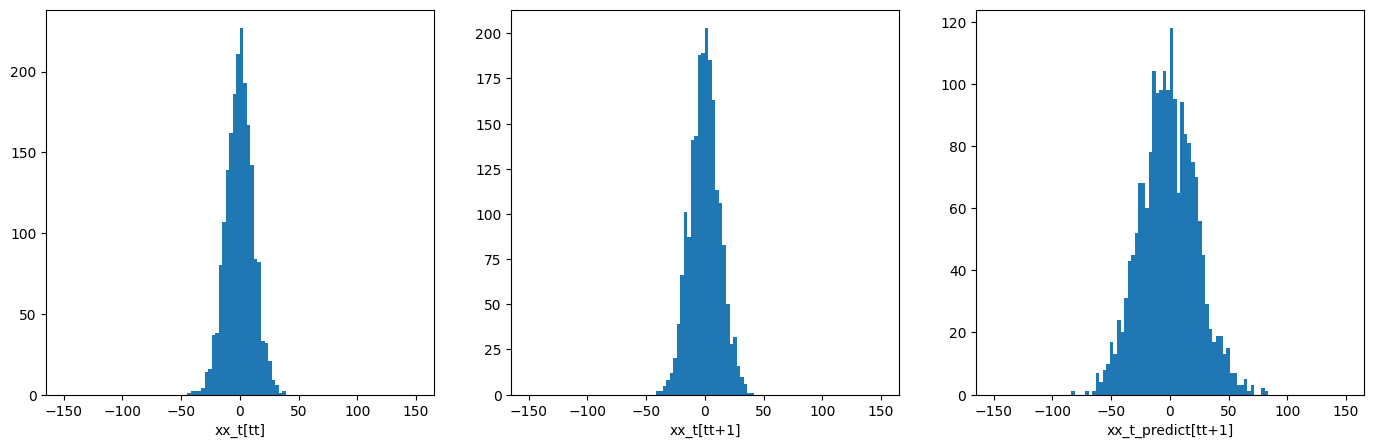

Step: 1; Beta: 0.115


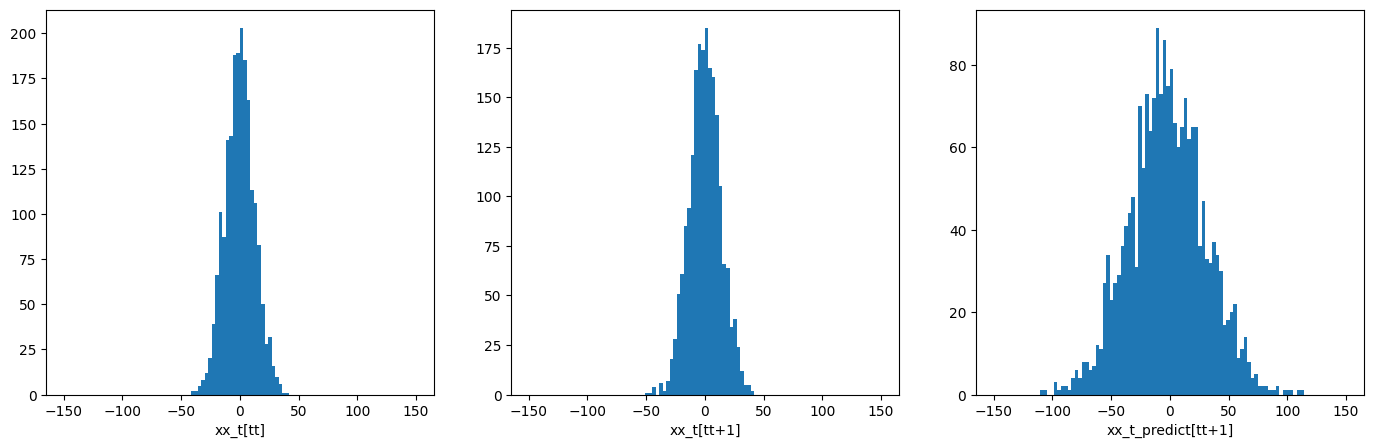

Step: 2; Beta: 0.1225


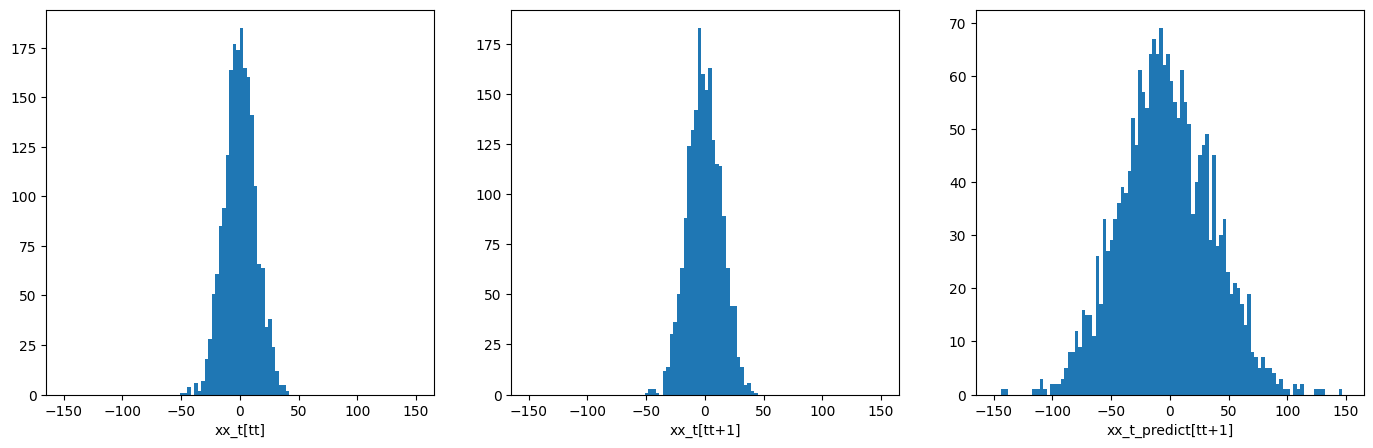

Step: 3; Beta: 0.13


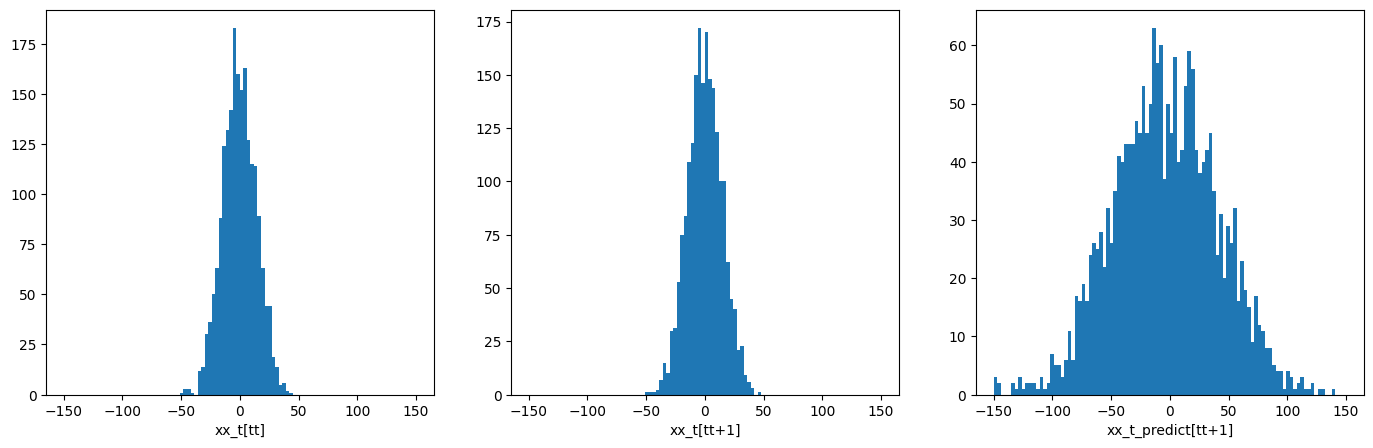

Step: 4; Beta: 0.1375


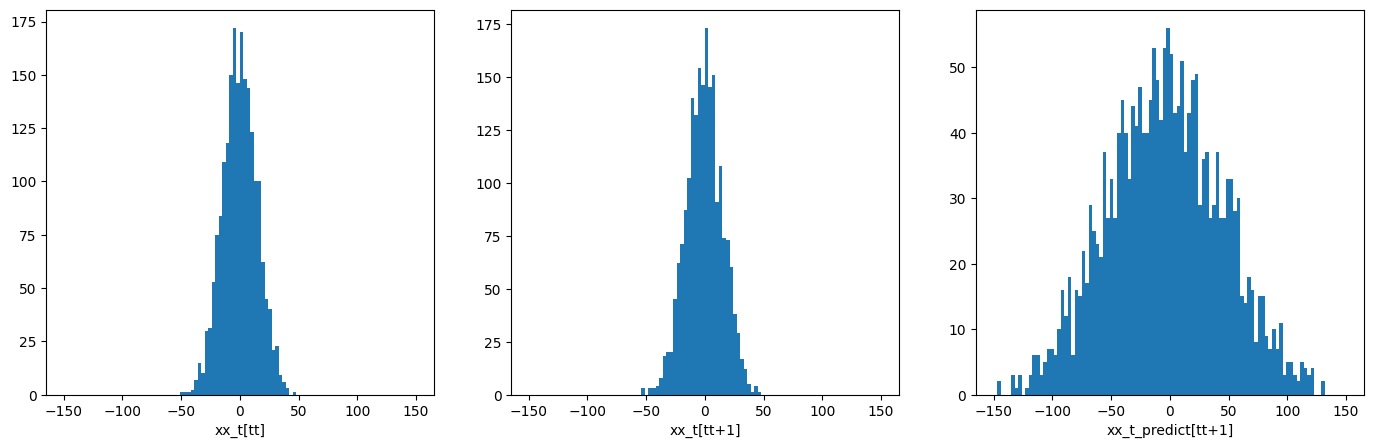

Step: 5; Beta: 0.14500000000000002


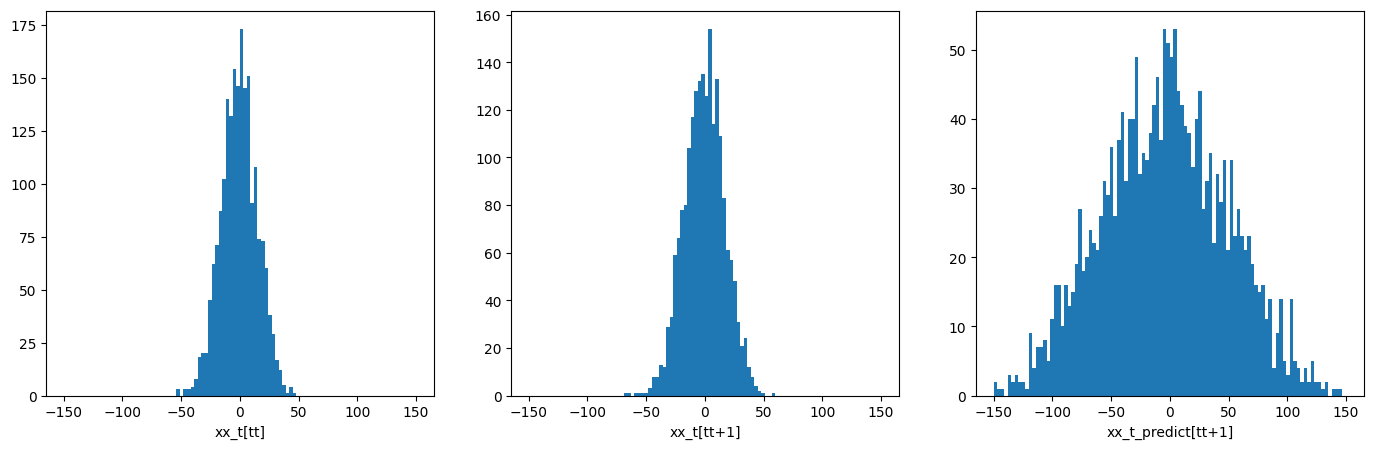

Step: 6; Beta: 0.15250000000000002


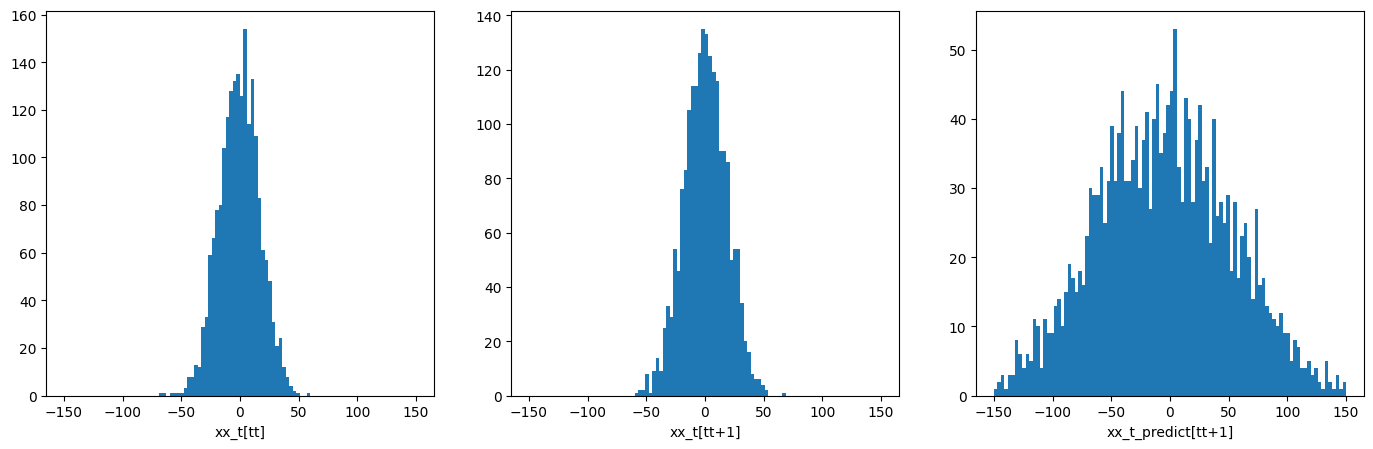

Step: 7; Beta: 0.16


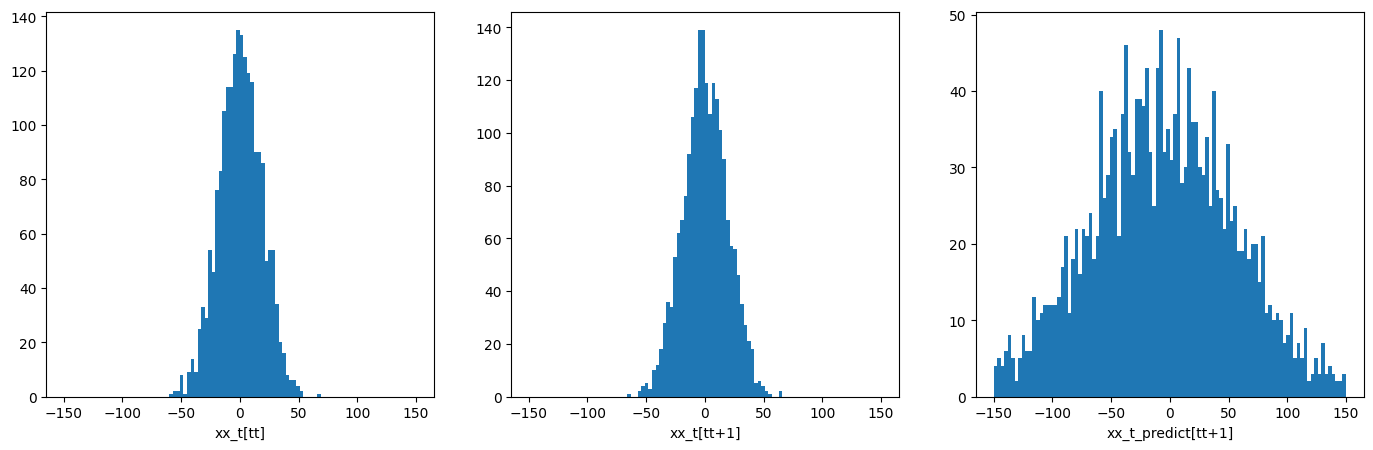

Step: 8; Beta: 0.16749999999999998


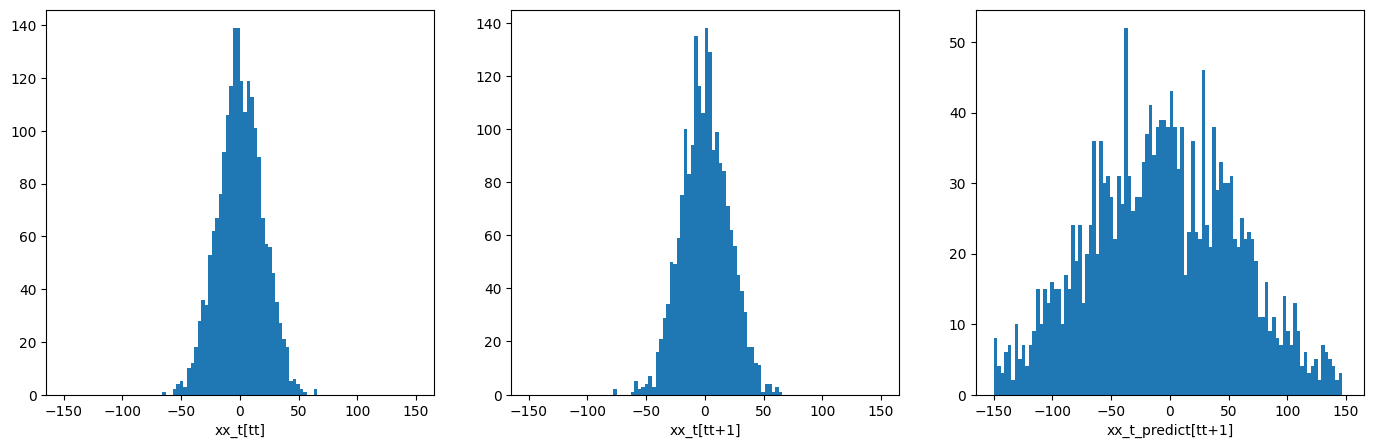

Step: 9; Beta: 0.175


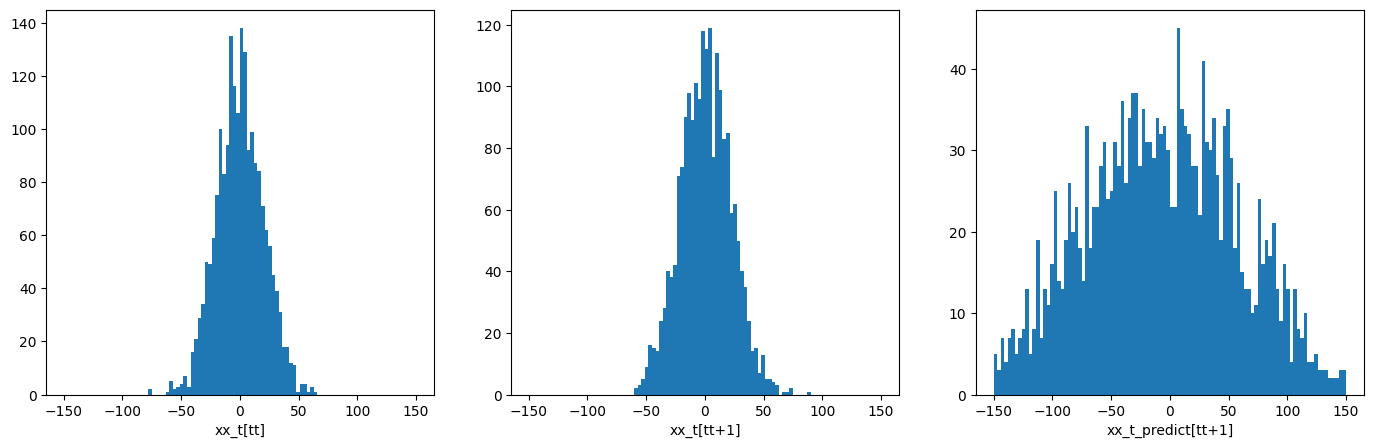

Step: 10; Beta: 0.1825


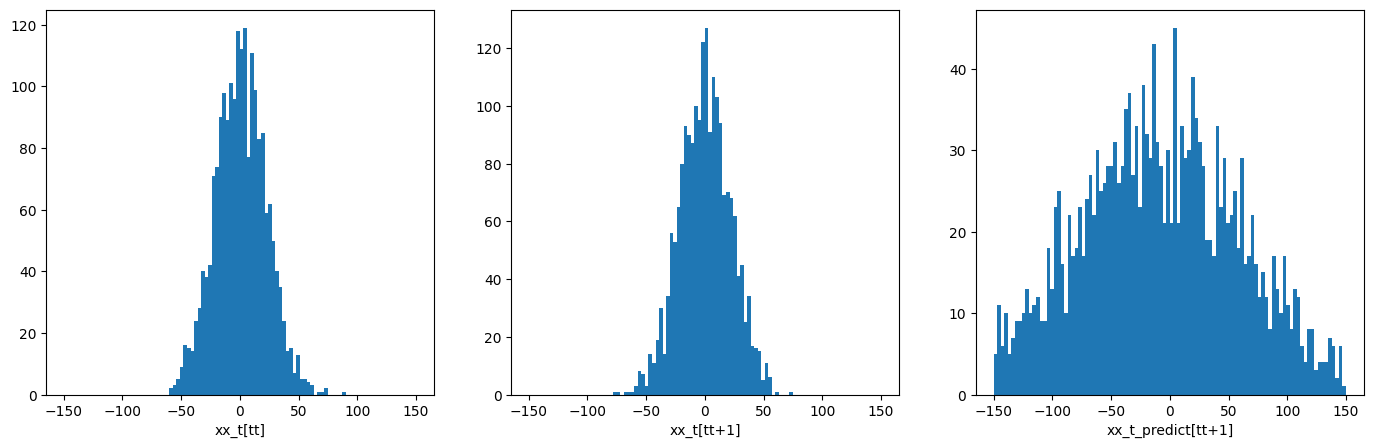

Step: 11; Beta: 0.19


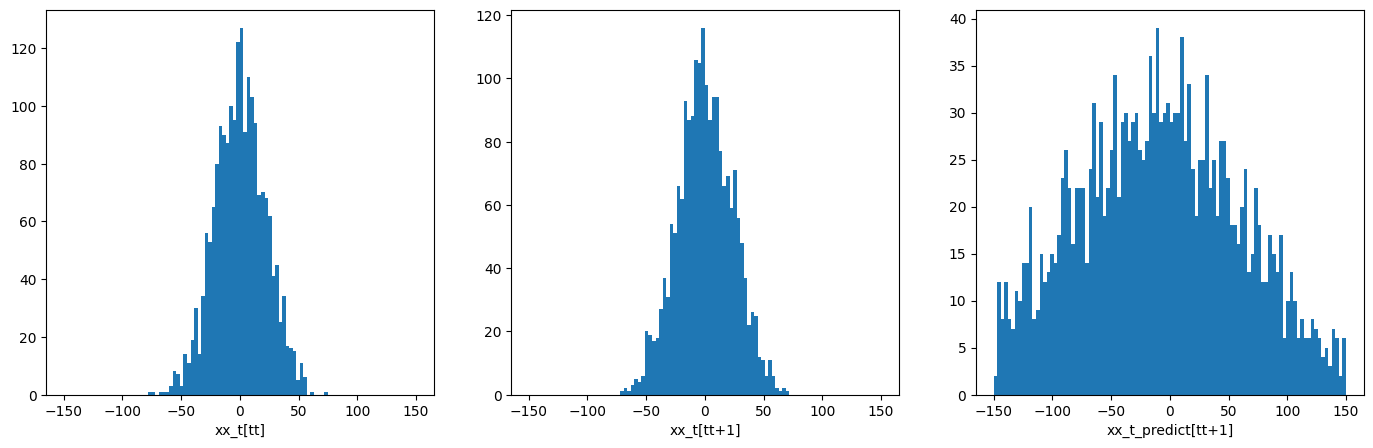

Step: 12; Beta: 0.1975


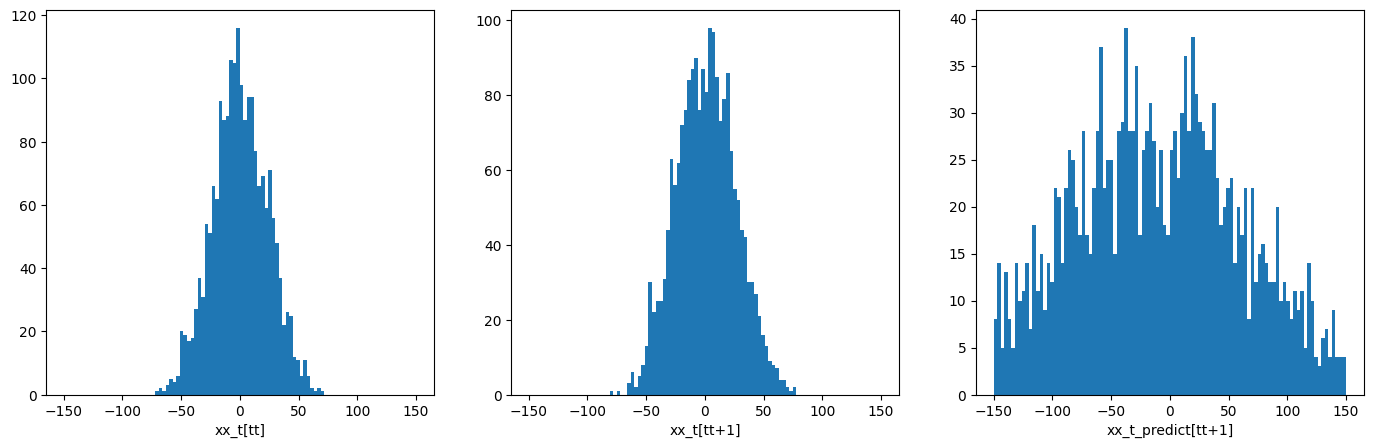

Step: 13; Beta: 0.20500000000000002


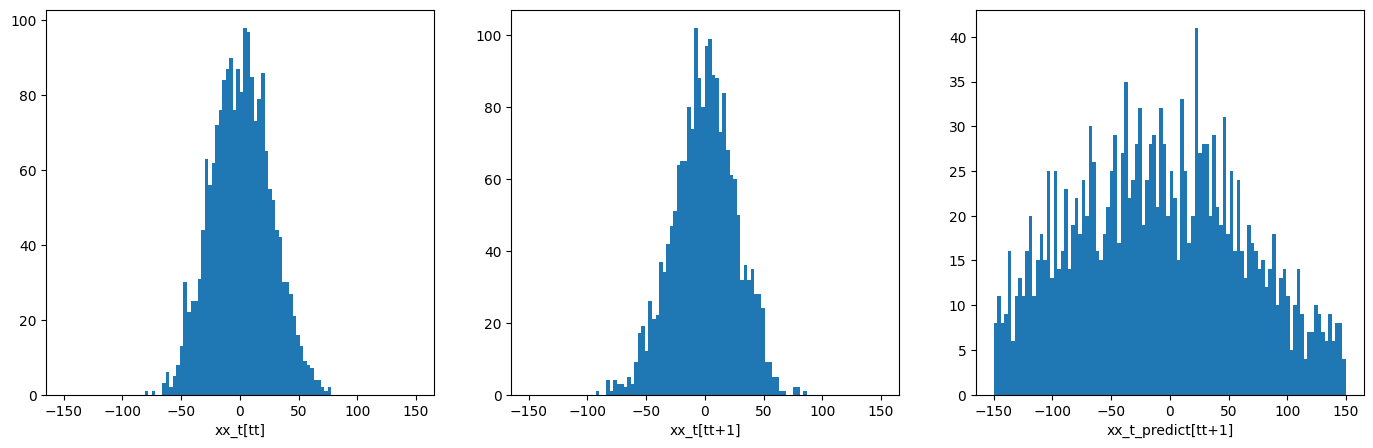

Step: 14; Beta: 0.21250000000000002


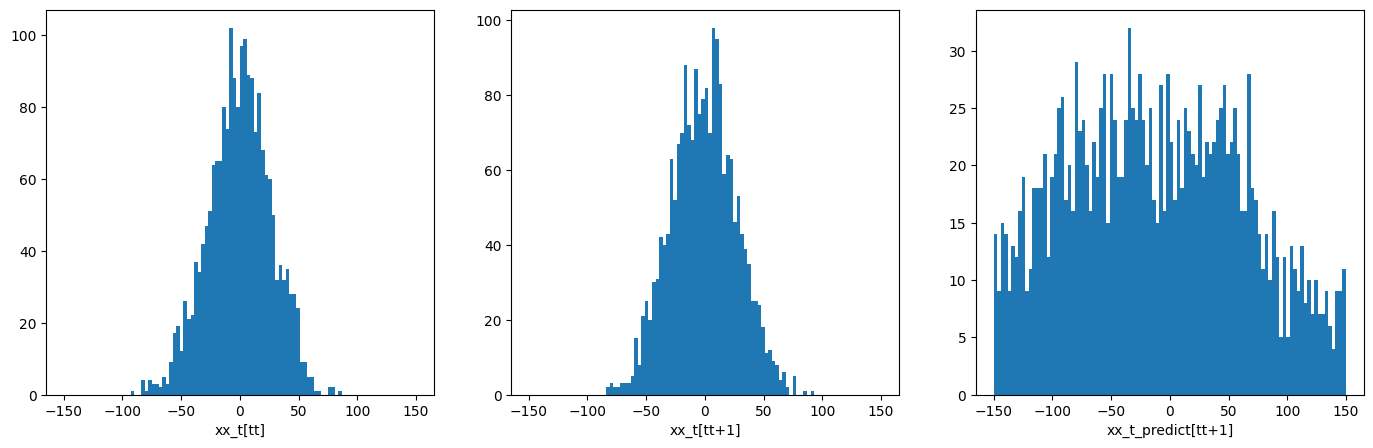

Step: 15; Beta: 0.22


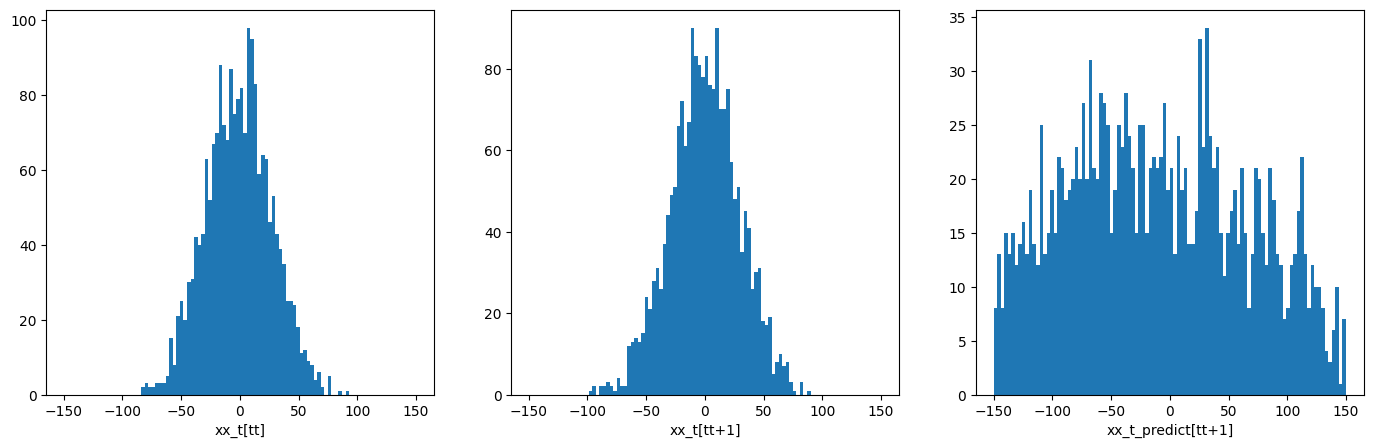

Step: 16; Beta: 0.2275


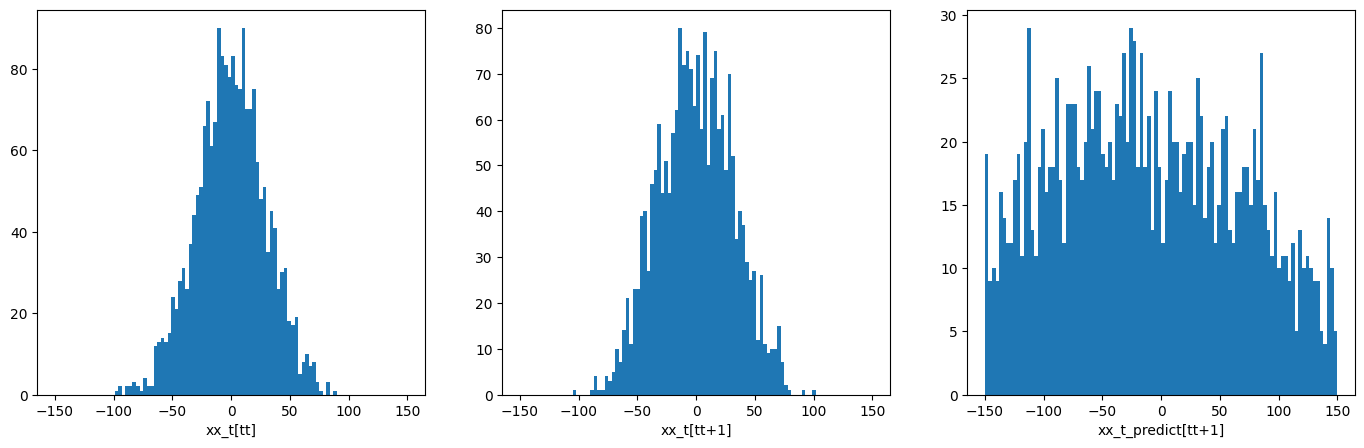

Step: 17; Beta: 0.235


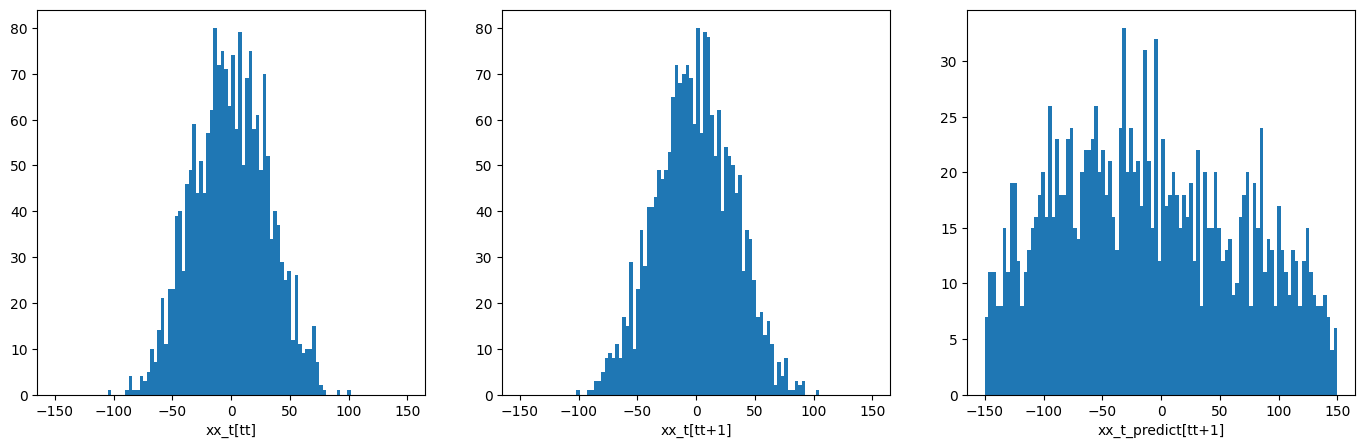

Step: 18; Beta: 0.24250000000000002


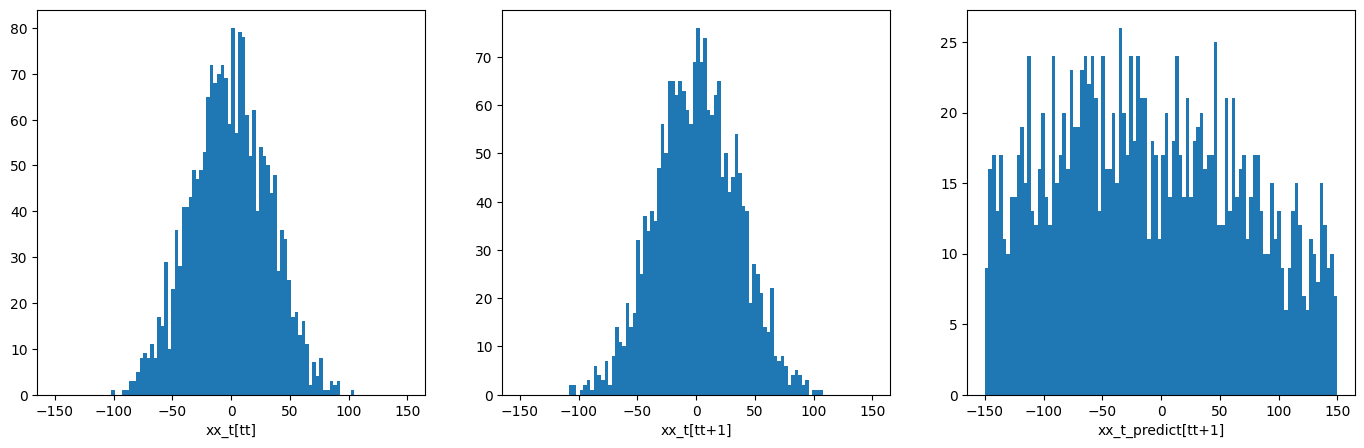

Step: 19; Beta: 0.25


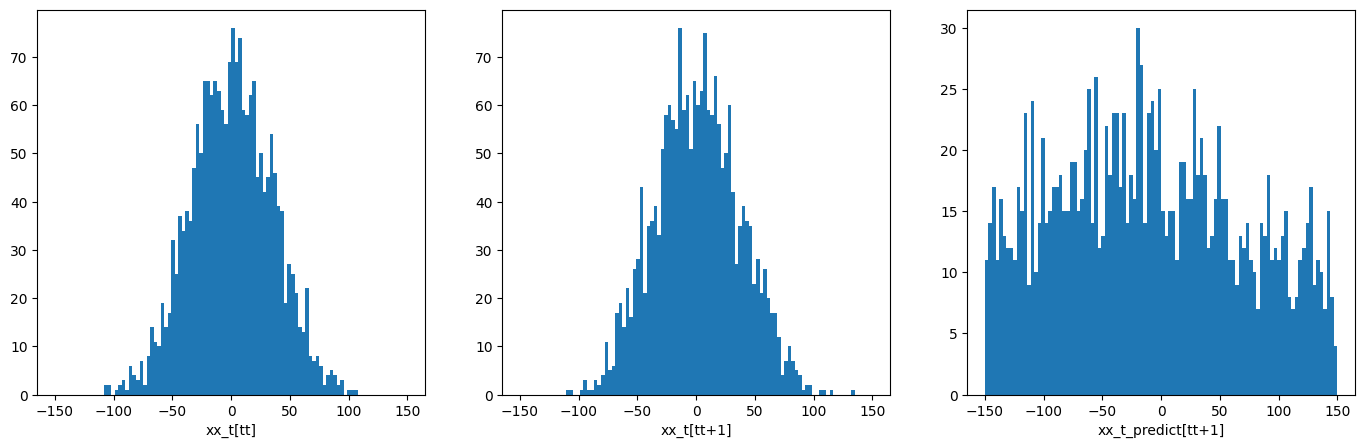

In [61]:

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 20
NS = 2000
NS_xxtilde = 2000
xxtilde_t = np.zeros((NT+1, NS, np.prod(seq_dim)))
xx_t = np.zeros((NT+1, NS, np.prod(seq_dim)))
xx_t_predict = np.zeros((NT+1, NS, np.prod(seq_dim)))
# xx_t[0,:,:] = np.random.normal(loc=0.0, scale=1.0, size=(NS,36))
xx_t[0,:,:] = sample_batch_prior(NS)
xx_t_predict[0,:,:] = sample_batch_prior(NS)
# xxtilde_prev = xx_t[0,:,:]
xxtilde_t[0] = xx_t[0]
p_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
logp_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
p_t_xx = np.zeros((NT, NS))
u_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde, np.prod(seq_dim)))
u_t_xx = np.zeros((NT, NS, np.prod(seq_dim)))

from UnetRes import UNetRes
device = torch.device('cpu')
model_u_t = UNetRes(1,1,bilinear=True, time_embed_dim=128)
model_u_t = model_u_t.to(device)
model_u_t.load_state_dict(torch.load("ckpt_unetvelocity-epoch36000.pth", map_location='cpu'))
# ising_t = Ising(6,2,0.25)
for tt in range(NT):
    beta_tt = 0.1+((0.25-0.1)*(tt+1)/NT)
    # sigma_tt = np.sqrt(2./beta_tt)
    print('Step: ' + str(tt) + "; Beta: "+str(beta_tt))
    ising_t = Ising(8,2,beta_tt)
    
    # xxtilde = sample_batch(NS_xxtilde)
    if tt == 0:
        xxtilde_t[tt+1] = ising_t.sample(NS_xxtilde, thermalSteps=1000, initial=torch.from_numpy(xxtilde_t[tt]).to(torch.float32)).detach().numpy()
    else:
        xxtilde_t[tt+1] = ising_t.sample(NS_xxtilde, thermalSteps=500, initial=torch.from_numpy(xxtilde_t[tt]).to(torch.float32)).detach().numpy()
    xxtilde = xxtilde_t[tt+1]

    plt.figure(figsize=(17,5))
    plt.subplot(131)
    plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(-150,150))
    plt.xlabel("xx_t[tt]")
    # plt.subplot(132)
    # plt.hist(xxtilde.sum(-1), bins=100, range=(-150,150))
    # plt.xlabel(r"xxtilde")
    u_t_xx[tt] = (xxtilde-xx_t[tt])
    sample_beta_tt = np.ones([NS,1])*beta_tt
    u_t_precit = model_u_t(torch.from_numpy(xx_t[tt].reshape(NS,1,8,8)).float(), torch.from_numpy(sample_beta_tt).float()).reshape(NS,64)
    # plt.subplot(133)
    # plt.scatter(xx_t[tt,:,0], u_t_xx[tt,:,0])
    # plt.xlabel("x_t[tt]")
    # plt.ylabel("u_t[tt]")
    
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:]
    xx_t_predict[tt+1,:,:] = xx_t_predict[tt,:,:]+u_t_precit.detach().numpy()
    plt.subplot(132)
    plt.hist(xx_t[tt+1,:,:].sum(-1), bins=100, range=(-150,150))
    plt.xlabel("xx_t[tt+1]")
    plt.subplot(133)
    plt.hist(xx_t_predict[tt+1,:,:].sum(-1), bins=100, range=(-150,150))
    plt.xlabel("xx_t_predict[tt+1]")
    plt.show()

In [43]:
eval_xx_t = xx_t[:-1]
eval_xx_t_label = xx_t[1:]
eval_u_t = u_t_xx
eval_beta_tt = torch.from_numpy(np.array([0.1+((0.25-0.1)*(tt+1)/NT) for tt in range(NT)]))[:,None].expand(20,2000).numpy()

In [44]:
np.save("eval_u_t",        eval_u_t)
np.save("eval_xx_t",       eval_xx_t)
np.save("eval_xx_t_label", eval_xx_t_label)
np.save("eval_beta_tt",    eval_beta_tt)

In [39]:
data_xx_t = np.concatenate([data_xx_t, xx_t[:-1]], axis=1)
data_xx_t_label = np.concatenate([data_xx_t_label, xx_t[1:]], axis=1)
data_u_t = np.concatenate([data_u_t, u_t_xx], axis=1)
data_beta_tt = np.concatenate([data_beta_tt, torch.from_numpy(np.array([0.1+((0.25-0.1)*(tt+1)/NT) for tt in range(NT)]))[:,None].expand(20,2000).numpy()], axis=1)

In [40]:
print(data_xx_t.shape, data_u_t.shape, data_beta_tt.shape)

(20, 10000, 64) (20, 10000, 64) (20, 10000)


In [41]:
np.save("data_u_t", data_u_t)
np.save("data_xx_t", data_xx_t)
np.save("data_xx_t_label", data_xx_t_label)
np.save("data_beta_tt", data_beta_tt)

In [ ]:
def fm_loss(model, samples, u_t_label):
    samples.requires_grad_(True)
    u_t_model = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [15]:
def fm_loss_CNN2d(model, samples, t, u_t_label, plot_u=False):
    samples.requires_grad_(True)
    batch_size = samples.shape[0]
    u_t_model = model(samples, t).reshape(batch_size,np.prod(seq_dim))
    # Compute the norm loss
    if plot_u:
        plt.figure(figsize=(11,5))
        plt.subplot(121)
        plt.scatter(samples.reshape(batchsize,np.prod(seq_dim))[:,0].detach().numpy(),u_t_label[:,0].detach().numpy(),s=3)
        plt.ylabel("u_t_label")
        plt.xlabel("x_t")
        plt.subplot(122)
        plt.scatter(samples.reshape(batchsize,np.prod(seq_dim))[:,0].detach().numpy(),u_t_model[:,0].detach().numpy(),s=3)
        plt.ylabel("u_t_model")
        plt.xlabel("x_t")
        plt.show()
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/milesial/Pytorch-UNet/issues/2

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# model_u_t = nn.Sequential(
#     nn.Linear(37, 128), nn.Softplus(),
#     nn.Linear(128, 128), nn.Softplus(),
#     nn.Linear(128, 36)
# )
# from model.dna_models import CNNModel2D
# 
# class Hyperparams():
#     def __init__(self, hidden_dim=16, num_cnn_stacks=1, dropout=0.0, cls_free_guidance=False, clean_data=False, channels=1):
#         self.hidden_dim = hidden_dim
#         self.dropout = dropout
#         self.kernel_size = 3
#         self.padding = 1
#         self.cls_free_guidance = cls_free_guidance
#         self.clean_data = clean_data
#         self.num_cnn_stacks = num_cnn_stacks
#         self.wandb = False
#         self.seq_dim = (6,6)
#         self.channels = channels
# 
#         self.classifier = False
# 
# hyperparams = Hyperparams(hidden_dim=128, num_cnn_stacks=5)
# model_u_t = TimeDependent2DCNN(hyperparams, 1, 1, classifier=False)

model_u_t = UNet(1,1)
optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

l_curve = []
batch_size = 1024
samples = np.zeros((batch_size, 6, 6))
print('[Time step, loss value, lr]')
beta_t = np.array([0.1+((0.4-0.1)*(tt+1)/NT) for tt in range(NT)])
sigma_t = np.array([np.sqrt(2./beta_tt) for beta_tt in beta_t])
for t in range(2000):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    # samples[:,0] = beta_t[t_idx]
    # samples[:,1:] = xx_t[t_idx, x_idx, :]
    samples = xx_t[t_idx, x_idx, :].reshape(batch_size,6,6,1)
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()
    if ((t % 10) == 0):
        loss = fm_loss_CNN2d(model_u_t, torch.tensor(samples).float(), torch.tensor(beta_t[t_idx]).float(), u_t_label, plot_u=True)
    else:
        loss = fm_loss_CNN2d(model_u_t, torch.tensor(samples).float(), torch.tensor(beta_t[t_idx]).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # scheduler.step(loss)
    
    if ((t % 10) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 10) == 0):
        print([t,loss.item()])

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
for t in range(60, 2000):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    # samples[:,0] = beta_t[t_idx]
    # samples[:,1:] = xx_t[t_idx, x_idx, :]
    samples = xx_t[t_idx, x_idx, :].reshape(batch_size,6,6,1)
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()/(1./NT)
    loss = fm_loss_CNN2d(model_u_t, torch.tensor(samples).float(), torch.tensor(beta_t[t_idx]).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    scheduler.step(loss)
    
    if ((t % 10) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 10) == 0):
        print([t,loss.item(),scheduler.get_last_lr()[0]])

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-3
for t in range(150, 155):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    # samples[:,0] = beta_t[t_idx]
    # samples[:,1:] = xx_t[t_idx, x_idx, :]
    samples = xx_t[t_idx, x_idx, :].reshape(batch_size,6,6,1)
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()/(1./NT)
    loss = fm_loss_CNN2d(model_u_t, torch.tensor(samples).float(), torch.tensor(beta_t[t_idx]).float(), u_t_label, plot_u=True)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # scheduler.step(loss)
    
    if ((t % 1) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 1) == 0):
        # print([t,loss.item(),scheduler.get_last_lr()[0]])
        print([t,loss.item()])

ii = 0  Beta = 0.100000


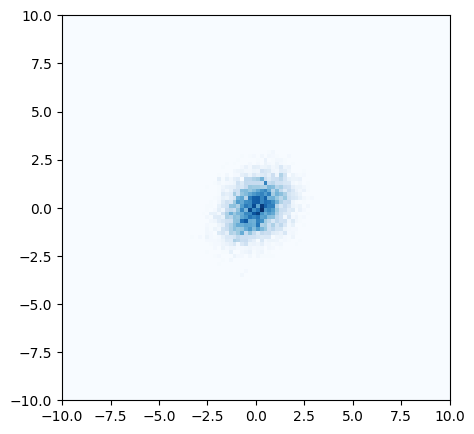

ii = 1  Beta = 0.115000


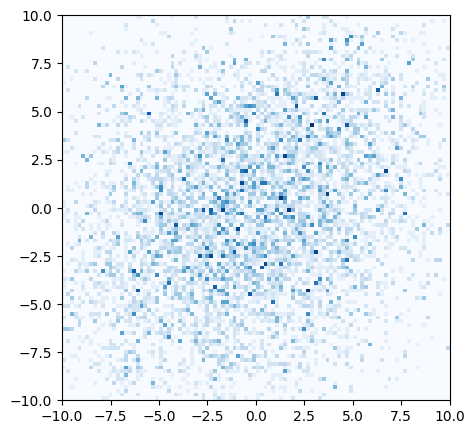

KeyboardInterrupt: 

In [141]:
def plot_flow(model):
    sample_size = 10**4
    # xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx = sample_batch_prior(sample_size)
    print("ii = %d  Beta = %f"%(0,0.1))
    plt.figure(figsize=(5,5))
    plt.hist2d(xx[:,0], xx[:,1], bins=100, cmap='Blues',range=np.array([(-10, 10.0), (-10, 10.0)]))
    plt.show()
    xx_t = []
    xx_t.append(xx)
    
    NT = 20
    beta_t = np.array([0.1+((0.4-0.1)*(tt+1)/NT) for tt in range(NT)])
    for ii in range(NT):
        beta_tt = beta_t[ii]
        # samples = torch.cat((torch.ones(sample_size, 1)*beta_tt, torch.from_numpy(xx)), axis = 1)
        # u_t = model(samples)
        samples = torch.from_numpy(xx).reshape(sample_size, 6, 6, 1)
        t = torch.ones(sample_size)*beta_tt
        u_t = model(samples, t).reshape(sample_size, 36)
        xx = xx + u_t.detach().numpy() * 1./NT
        print("ii = %d  Beta = %f"%(ii+1,beta_tt))
        plt.figure(figsize=(5,5))
        plt.hist2d(xx[:,0], xx[:,1], bins=100, cmap='Blues',range=np.array([(-10, 10.0), (-10, 10.0)]))
        plt.show()
        xx_t.append(xx)
    xx_t = np.array(xx_t)

    plt.figure(figsize=(11,5))
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii))
        axes[ii_x,ii_y].hist2d(xx_t[ii*1,:,0], xx_t[ii*1,:,1],bins=100, cmap='Blues',range=np.array([(-10, 10.0), (-10, 10.0)]))
        
    plt.show()
    return xx_t

# print(u_t_xx.shape)
xx_t_predict = plot_flow(model_u_t)

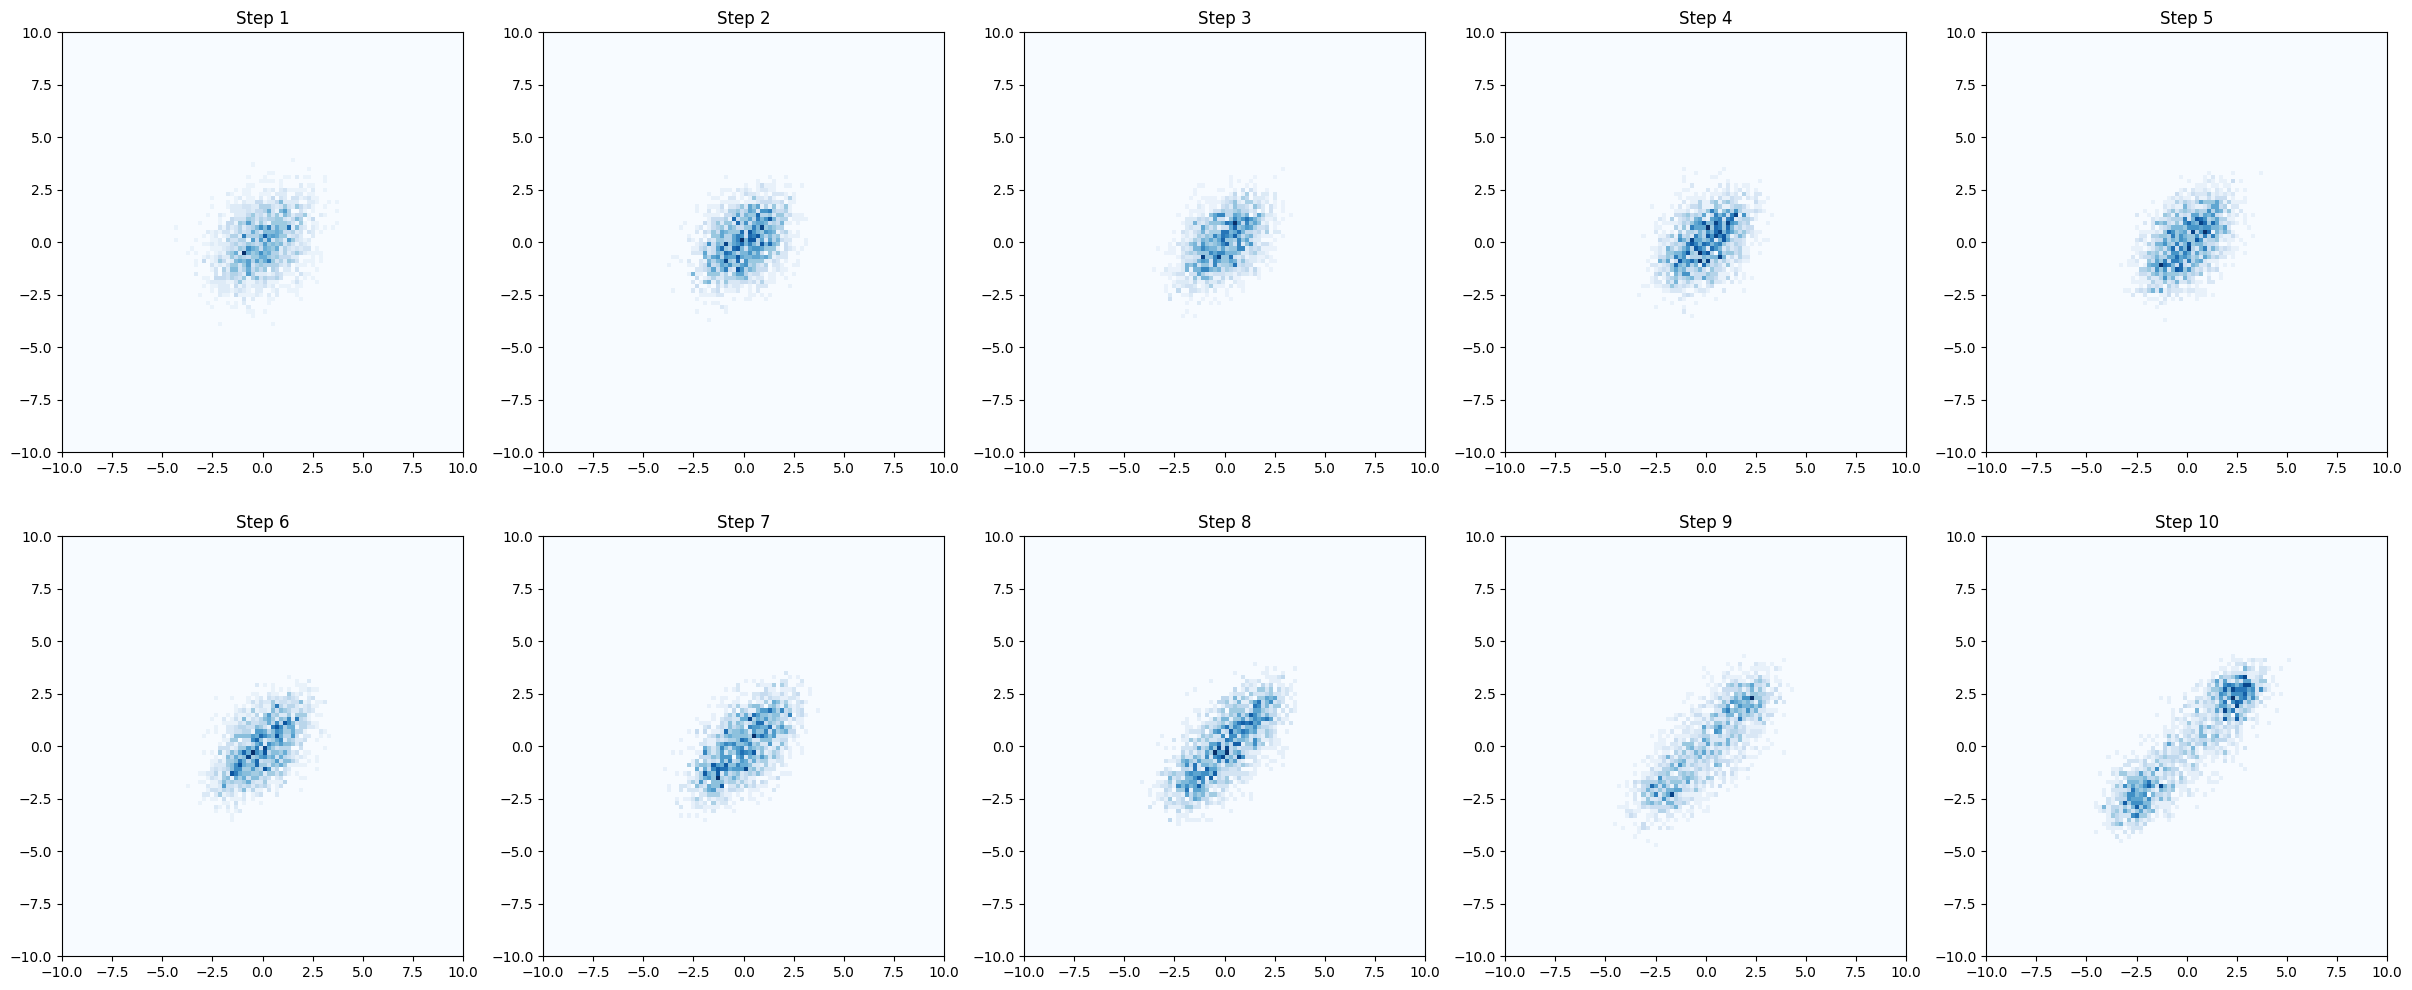

In [142]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii*10,:,2], xx_t[ii*10,:,3], bins=100, cmap='Blues',range=np.array([(-10, 10.0), (-10, 10.0)]))
plt.show()

# Flow matching with dirichlet path

In [ ]:

def pbc(i,L):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i

def ising_boltzman_prob(logits, J=1):
    assert logits.shape[-1] == 2
    B,H,W,K = logits.shape
    spins = torch.sum(logits*torch.tensor([-1,1], device=logits.device)[None,None,None,:], dim=-1)

    E = torch.zeros(B, device=logits.device)
    for i in range(H):
            E += -(spins[:,i,:]*spins[:,pbc(i-1,L=H),:]*J).sum(dim=-1)
            E += -(spins[:,i,:]*spins[:,pbc(i+1,L=H),:]*J).sum(dim=-1)
    for j in range(W):
            E += -(spins[:,:,j]*spins[:,:,pbc(j-1,L=H)]*J).sum(dim=1)
            E += -(spins[:,:,j]*spins[:,:,pbc(j+1,L=H)]*J).sum(dim=1)

    # for i in range(H):
    #     for j in range(W):
    #         E += -spins[:,i,j]*spins[:,pbc(i-1,L=H),j]*J
    #         E += -spins[:,i,j]*spins[:,pbc(i+1,L=H),j]*J
    #         E += -spins[:,i,j]*spins[:,i,pbc(j-1,L=H)]*J
    #         E += -spins[:,i,j]*spins[:,i,pbc(j+1,L=H)]*J

    E /= 2
    return E

In [ ]:
dataset = np.load("data/ising-latt6x6-T4.0/latt6x6/buffer-S4.00.npy")
dataset[np.where(dataset==-1)]=0
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size)
    return dataset[idx]

In [ ]:
sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 50
NS = 1000
NS_xxtilde = 1000
xx_t = torch.zeros((NT+1, NS, 36))
# xx_t[0,:,:] = np.random.normal(size=(NS,36))
alphas = torch.ones([NS, 36, 2])
xx_t[0,:,:] = torch.distributions.Dirichlet(alphas).sample()[:,:,0]

p_t_xx_xxtilde = torch.zeros((NT, NS, NS_xxtilde))
p_t_xx = torch.zeros((NT, NS))
u_t_xx_xxtilde = torch.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = torch.zeros((NT, NS, 36))

for tt in range(NT):
    print('Step: ' + str(tt))
    sigma_tt = (1 - (1-sigma_min) * tt / NT)
    xxtilde = torch.from_numpy(sample_batch(NS_xxtilde)).to(torch.int64)
    e_xxtilde = ising_boltzman_prob(torch.nn.functional.one_hot(xxtilde.reshape(-1), num_classes=2).reshape(NS_xxtilde, 6,6, 2))
    Z = torch.exp(-e_xxtilde*sigma_tt).sum()

    rand_indices = torch.randint(0, 2, (NS, NS, 36))
    rand_onehot = torch.zeros([NS, NS, 36, 2])
    rand_onehot.scatter_(-1, rand_indices.unsqueeze(-1), 1)
    alphas = torch.ones([NS, NS, 36, 2])
    alphas = alphas + sigma_tt*rand_onehot.reshape(NS, NS, 36, 2)
    xx = torch.distributions.Dirichlet(alphas).sample()
    e_xx = ising_boltzman_prob(rand_onehot.reshape(-1,6,6,2)).reshape(NS,NS)
    for ii in range(NS):
        p_xx_xxtilde = torch.exp(-(e_xx[ii,:]-e_xxtilde)*sigma_tt)/Z
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36)) / sigma_tt
    p_t_xx[tt, :] = torch.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)
    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = torch.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:] * 0.02

In [ ]:
spins = xx_t*(-1.)+(1-xx_t)*1

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(spins[(ii)*5,:,0], spins[ii+1,:,1],bins=100, cmap='Blues',range=np.array([(-3.5, 3.5), (-3.5, 3.5)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2]) 
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(spins[(ii)*5,:,:].sum(-1),bins=100)
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlim((-50,50))
plt.show()

In [ ]:
raise RuntimeError

# Test Harmonic oscillator

In [ ]:
class Harmonic_Oscillator:
    def __init__(self,T):
        self.T = T
        self.kappa = 1.0/T
        self.nvars=[36]

    def energy(self, x):
        return ((x)**2*self.kappa).sum(axis=1)


    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)

    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()

        

In [ ]:


plt.rcParams['figure.figsize'] = (17, 5)
harmonic_oscillator = Harmonic_Oscillator(10)
xx0 = harmonic_oscillator.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(5)
xx1 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(4)
xx2 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(2.5)
xx3 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

# Test continous x with nearest neighbor interactions

In [ ]:
class nn_harmonic_oscillator:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        K = self.lattice.Adj*beta
        self.K = torch.from_numpy(K).to(torch.float32)
        # w, v = eigh(self.K)    
        # offset = 0.1-w.min()
        # print("offset", offset)
        # self.K += np.eye(w.size)*offset
        # sign, logdet = np.linalg.slogdet(self.K)
        # self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        return -0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.K) * x.reshape(-1, self.nvars[0])).sum(dim=1)

    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()


In [ ]:


plt.rcParams['figure.figsize'] = (17, 5)
nn_oscillator = nn_harmonic_oscillator(6,2,0.1)
xx0 = nn_oscillator.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.2)
xx1 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.25)
xx2 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.4)
xx3 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

# Test the gaussian integral continuous Ising model
## Sample by annealing
$k_BT=\infty \rightarrow 10J\rightarrow 5J\rightarrow 4J\rightarrow 2.5J$

### $k_BT=\infty \rightarrow 10J$

64 torch.Size([10000, 64])


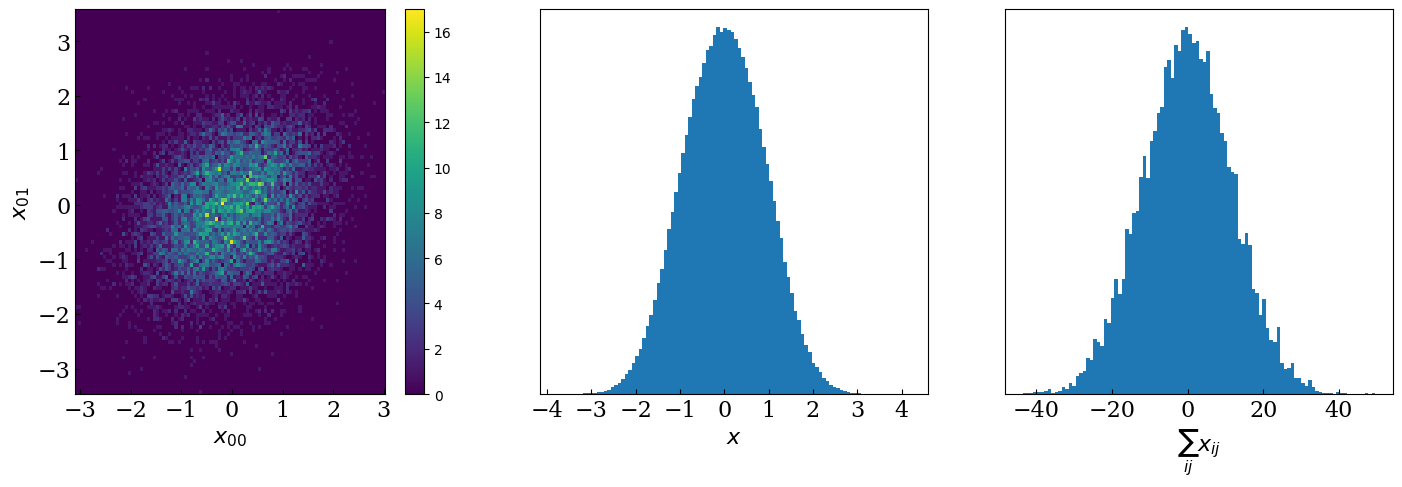

In [9]:
import torch

plt.rcParams['figure.figsize'] = (17, 5)
ising = Ising(8,2,0.1)
xx0 = ising.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,np.prod(seq_dim))[:,0], xx0.reshape(-1,np.prod(seq_dim))[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,np.prod(seq_dim)).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=10J \rightarrow 5J$

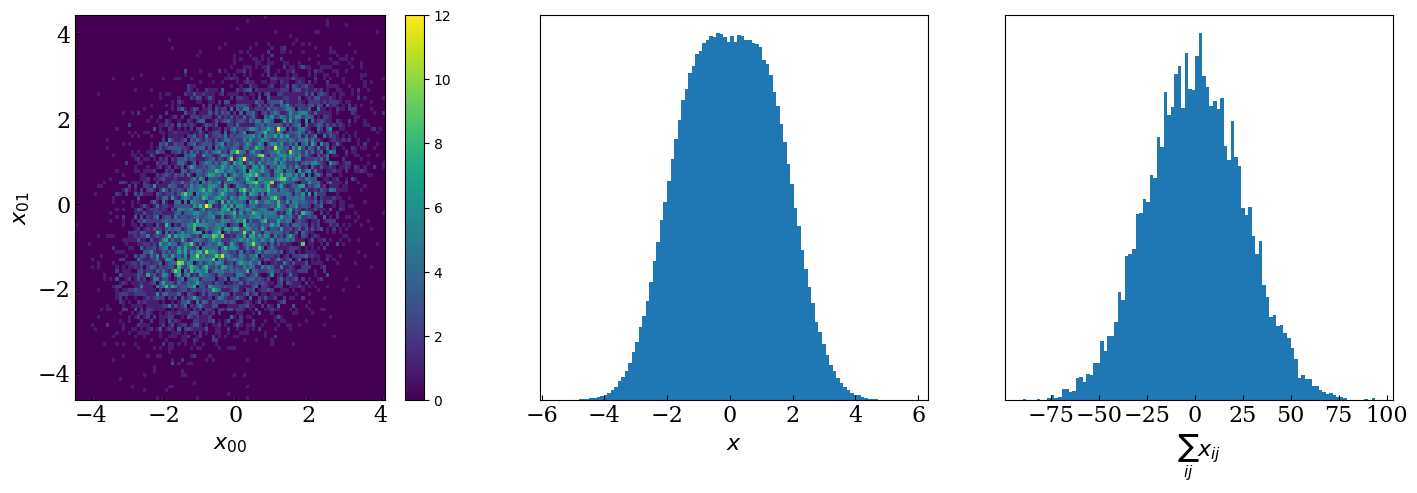

In [10]:
ising = Ising(8,2,0.2)
xx1 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,np.prod(seq_dim))[:,0], xx1.reshape(-1,np.prod(seq_dim))[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,np.prod(seq_dim)).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=5J \rightarrow 4J$

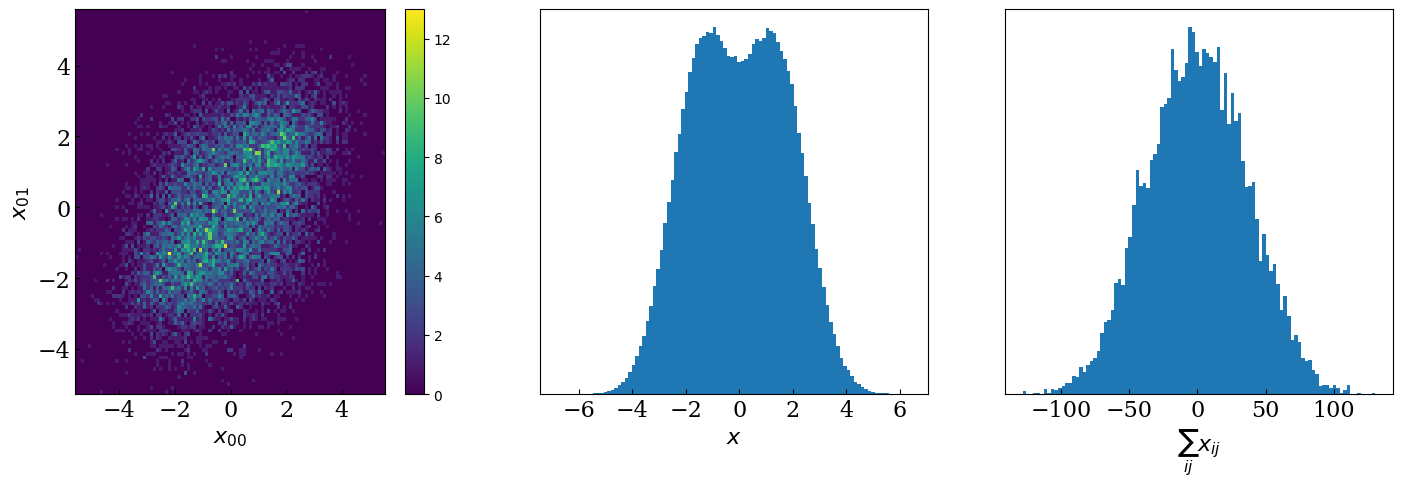

In [11]:
ising = Ising(8,2,0.25)
xx2 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,np.prod(seq_dim))[:,0], xx2.reshape(-1,np.prod(seq_dim))[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,np.prod(seq_dim)).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=4J \rightarrow 2.5J$

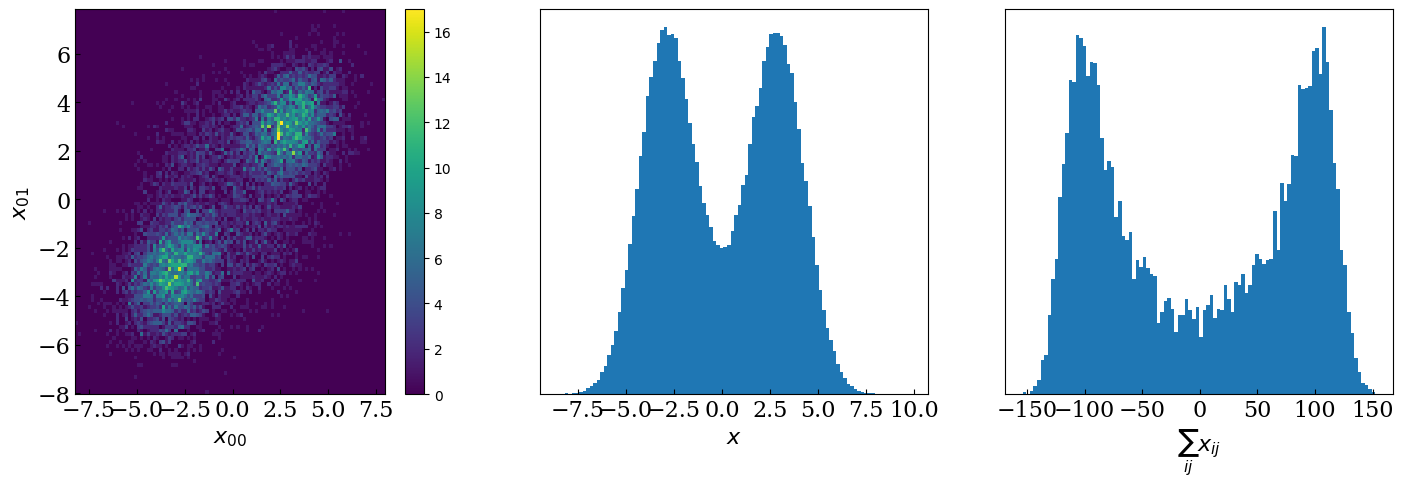

In [8]:
ising = Ising(6,2,0.4)
xx3 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

#### MSD

In [ ]:
x_t_list = []
x_t = xx3
ising = Ising(6,2,0.4)
for t in range(20000):
    x_t = ising.sample(1000, thermalSteps = 1, interSteps=1, initial=x_t)
    x_t_list.append(x_t.detach().numpy())
x_t_list = np.array(x_t_list)
MSD_t_list = []
for j in range(1, x_t_list.shape[0]):
    MSD_t_list.append(((x_t_list[j]-x_t_list[0])**2).mean(axis=0))
MSD_t_list = np.array(MSD_t_list)


In [ ]:
print(MSD_t_list.shape)

In [ ]:
from scipy.optimize import curve_fit
def slope(t,s,d0):
    return d0+s*t
popt_list = []
pcov_list = []
for i in range(36):
    trange = np.arange(5001,20000)
    popt, pcov = curve_fit(slope, trange, MSD_t_list[5000:,i])
    popt_list.append(popt)
    pcov_list.append(pcov)
    plt.figure()
    plt.plot(MSD_t_list[:,i])
    plt.plot(trange, slope(trange,*popt))
    plt.title("Site %d"%i)

In [ ]:
popt_list = np.array(popt_list)
D = popt_list.T[0]/0.1/2
print(popt_list.shape)
print(D)

In [ ]:
plt.figure()
plt.subplot(131)
_ = plt.hist2d(x_t_list[100].reshape(-1,36)[:,0], x_t_list[100].reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(x_t_list[100].reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(x_t_list[100].reshape(-1,36).sum(-1), bins=100)

In [ ]:
plt.figure()
plt.subplot(131)
_ = plt.hist2d(x_t_list[-1].reshape(-1,36)[:,0], x_t_list[-1].reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(x_t_list[-1].reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(x_t_list[-1].reshape(-1,36).sum(-1), bins=100)